## 1. Imports and Setup

In [30]:
import torch
import torch.nn as nn
import warnings

# Suppress expected warnings about efficiency in small test models
warnings.filterwarnings("ignore", message="The sketching layer uses more parameters")
warnings.filterwarnings("ignore", message="Tensor Core not utilized")

# Import tuner components
from panther.tuner.SkAutoTuner import (
    SKAutoTuner,
    LayerConfig,
    TuningConfigs,
    OptunaSearch,
    ModelVisualizer,
    Categorical,
    Int,
    Float,
)

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All imports successful!
PyTorch version: 2.6.0+cu124
CUDA available: True


## 2. Define Test Models

We'll create several models with different architectures to test various tuner capabilities.

In [31]:
class SimpleMLPModel(nn.Module):
    """Simple MLP with Linear layers of various sizes."""
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(256, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 64)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        return self.fc4(x)


class EncoderDecoderModel(nn.Module):
    """Encoder-Decoder style model for testing pattern-based layer selection."""
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class ConvModel(nn.Module):
    """Model with Conv2d layers for testing convolution tuning."""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.conv3(x)
        x = self.pool(x)
        x = self.flatten(x)
        return self.fc(x)


print("Models defined successfully!")

Models defined successfully!


## 3. Visualize Model Structures

Before tuning, let's inspect the model structures using the `ModelVisualizer`.

In [32]:
# Create model instances
mlp_model = SimpleMLPModel()
enc_dec_model = EncoderDecoderModel()
conv_model = ConvModel()

print("Created model instances")

Created model instances


In [33]:
print("=" * 60)
print("SimpleMLPModel - Module Tree")
print("=" * 60)
ModelVisualizer.print_module_tree(mlp_model, "SimpleMLPModel")

SimpleMLPModel - Module Tree
SimpleMLPModel (SimpleMLPModel)/
└─ fc1 (Linear)
└─ fc2 (Linear)
└─ fc3 (Linear)
└─ fc4 (Linear)
└─ relu1 (ReLU)
└─ relu2 (ReLU)
└─ relu3 (ReLU)


In [34]:
print("\n" + "=" * 60)
print("EncoderDecoderModel - Module Tree")
print("=" * 60)
ModelVisualizer.print_module_tree(enc_dec_model, "EncoderDecoderModel")


EncoderDecoderModel - Module Tree
EncoderDecoderModel (EncoderDecoderModel)/
└─ decoder (Sequential)/
│   ├─ 0 (Linear)
│   ├─ 1 (ReLU)
│   ├─ 2 (Linear)
│   ├─ 3 (ReLU)
│   ├─ 4 (Linear)
└─ encoder (Sequential)/
    └─ 0 (Linear)
    └─ 1 (ReLU)
    └─ 2 (Linear)
    └─ 3 (ReLU)
    └─ 4 (Linear)


In [35]:
print("\n" + "=" * 60)
print("ConvModel - Module Tree")
print("=" * 60)
ModelVisualizer.print_module_tree(conv_model, "ConvModel")


ConvModel - Module Tree
ConvModel (ConvModel)/
└─ conv1 (Conv2d)
└─ conv2 (Conv2d)
└─ conv3 (Conv2d)
└─ fc (Linear)
└─ flatten (Flatten)
└─ pool (AdaptiveAvgPool2d)
└─ relu1 (ReLU)
└─ relu2 (ReLU)


In [36]:
print("\n" + "=" * 60)
print("Model Summary - SimpleMLPModel")
print("=" * 60)
ModelVisualizer.print_model_summary(mlp_model)


Model Summary - SimpleMLPModel
Model Summary (Total trainable parameters: 304,064)
--------------------------------------------------------------------------------
Layer Name                               Layer Type                Parameters     
--------------------------------------------------------------------------------
fc1                                      Linear                    131,584        
relu1                                    ReLU                      0              
fc2                                      Linear                    131,328        
relu2                                    ReLU                      0              
fc3                                      Linear                    32,896         
relu3                                    ReLU                      0              
fc4                                      Linear                    8,256          


In [37]:
print("\n" + "=" * 60)
print("Model Summary - EncoderDecoderModel")
print("=" * 60)
ModelVisualizer.print_model_summary(enc_dec_model)


Model Summary - EncoderDecoderModel
Model Summary (Total trainable parameters: 1,183,488)
--------------------------------------------------------------------------------
Layer Name                               Layer Type                Parameters     
--------------------------------------------------------------------------------
encoder                                  Sequential                295,808        
encoder.0                                Linear                    131,584        
encoder.1                                ReLU                      0              
encoder.2                                Linear                    131,328        
encoder.3                                ReLU                      0              
encoder.4                                Linear                    32,896         
decoder                                  Sequential                295,936        
decoder.0                                Linear                    33,024         


## 4. Define Evaluation Function

The tuner needs an evaluation function to score different configurations.

In [38]:
def create_eval_func(input_shape, target_shape=None):
    """
    Create an evaluation function for a given model.
    Uses a simple forward pass and computes a dummy accuracy based on output variance.
    """
    def eval_func(model):
        model.eval()
        with torch.no_grad():
            x = torch.randn(input_shape)
            output = model(x)
            # Dummy score: use negative mean squared value (higher is better for lower outputs)
            # This is just for testing - in reality you'd use real accuracy
            score = -output.abs().mean().item() + 1.0
        return score
    return eval_func

# Create evaluation functions for each model
mlp_eval_func = create_eval_func((4, 256))  # batch_size=4, input_dim=256
enc_dec_eval_func = create_eval_func((4, 256))
conv_eval_func = create_eval_func((4, 3, 32, 32))  # batch_size=4, 3 channels, 32x32

# Test eval functions
print("Testing evaluation functions:")
print(f"  MLP model score: {mlp_eval_func(mlp_model):.4f}")
print(f"  Encoder-Decoder model score: {enc_dec_eval_func(enc_dec_model):.4f}")
print(f"  Conv model score: {conv_eval_func(conv_model):.4f}")

Testing evaluation functions:
  MLP model score: 0.9344
  Encoder-Decoder model score: 0.9743
  Conv model score: 0.9508


## 5. Test AUTO Parameter Recommendation

The `"auto"` parameter tells the tuner to automatically recommend parameter values based on layer dimensions.

In [39]:
# Create a fresh model for testing auto params
auto_model = SimpleMLPModel()

# Configuration using "auto" for automatic parameter recommendation
auto_config = TuningConfigs([
    LayerConfig(
        layer_names=["fc1", "fc2", "fc3", "fc4"],  # Select all Linear layers
        params="auto",  # <<< AUTO PARAMETER RECOMMENDATION
        separate=True,
        copy_weights=True,
    )
])

print("Created LayerConfig with params='auto'")
print(f"\nOriginal config: {auto_config}")

Created LayerConfig with params='auto'

Original config: TuningConfigs(configs=[LayerConfig(layer_names=['fc1', 'fc2', 'fc3', 'fc4'], params=auto, separate=True, copy_weights=True)])


In [40]:
# Create tuner to see how "auto" is resolved
search = OptunaSearch(n_trials=4, seed=42)

auto_tuner = SKAutoTuner(
    model=auto_model,
    configs=auto_config,
    accuracy_eval_func=mlp_eval_func,
    search_algorithm=search,
    verbose=True,  # Enable verbose to see what's happening
)

print("\n" + "=" * 60)
print("RESOLVED CONFIGS (after 'auto' expansion)")
print("=" * 60)

# Print the resolved configs
resolved_configs = auto_tuner.getConfigs()
print(f"\nNumber of resolved configs: {len(resolved_configs)}")

for i, config in enumerate(resolved_configs):
    print(f"\n--- Config {i+1} ---")
    print(f"Layer names: {config.layer_names}")
    print(f"Parameters:")
    for param_name, param_spec in config.params.items():
        print(f"  {param_name}: {param_spec}")
    print(f"Separate: {config.separate}")
    print(f"Copy weights: {config.copy_weights}")


RESOLVED CONFIGS (after 'auto' expansion)

Number of resolved configs: 4

--- Config 1 ---
Layer names: ['fc4']
Parameters:
  num_terms: [1, 2, 3]
  low_rank: [16]
Separate: True
Copy weights: True

--- Config 2 ---
Layer names: ['fc3']
Parameters:
  num_terms: [1, 2, 3]
  low_rank: [16, 32]
Separate: True
Copy weights: True

--- Config 3 ---
Layer names: ['fc1']
Parameters:
  num_terms: [1, 2, 3]
  low_rank: [16, 32, 64]
Separate: True
Copy weights: True

--- Config 4 ---
Layer names: ['fc2']
Parameters:
  num_terms: [1, 2, 3]
  low_rank: [16, 32, 64]
Separate: True
Copy weights: True


### Run Tuning with AUTO Parameters

In [41]:
print("Starting tuning with AUTO parameters...")
print("=" * 60)

best_params_auto = auto_tuner.tune()

print("\n" + "=" * 60)
print("TUNING COMPLETE - Best Parameters")
print("=" * 60)

for layer_name, data in best_params_auto.items():
    print(f"\nLayer: {layer_name}")
    if data and data.get('params'):
        print(f"  Best params: {data['params']}")
    else:
        print("  No params found")

[I 2026-01-02 22:44:12,769] A new study created in memory with name: skautotuner_study
[I 2026-01-02 22:44:12,776] A new study created in memory with name: skautotuner_study
[I 2026-01-02 22:44:12,783] A new study created in memory with name: skautotuner_study
[I 2026-01-02 22:44:12,792] A new study created in memory with name: skautotuner_study


Starting tuning with AUTO parameters...
Tuning layer: fc4
Trying parameters: {'num_terms': 2, 'low_rank': 16}
Replaced fc4 with sketched version using parameters: {'num_terms': 2, 'low_rank': 16}
run: 1/1 - accuracy_score: 0.9263394773006439, speed_score: None, final score: 0.9263394773006439
Tried parameters: {'num_terms': 2, 'low_rank': 16}, accuracy_score: 0.9263394773006439, speed_score: None, final score: 0.9263394773006439
Trying parameters: {'num_terms': 1, 'low_rank': 16}
Replaced fc4 with sketched version using parameters: {'num_terms': 1, 'low_rank': 16}
run: 1/1 - accuracy_score: 0.9274584650993347, speed_score: None, final score: 0.9274584650993347
Tried parameters: {'num_terms': 1, 'low_rank': 16}, accuracy_score: 0.9274584650993347, speed_score: None, final score: 0.9274584650993347
Trying parameters: {'num_terms': 2, 'low_rank': 16}
Replaced fc4 with sketched version using parameters: {'num_terms': 2, 'low_rank': 16}
run: 1/1 - accuracy_score: 0.9396375715732574, speed_s

In [42]:
# Get results as DataFrame
print("\n" + "=" * 60)
print("TUNING RESULTS DATAFRAME")
print("=" * 60)

results_df = auto_tuner.get_results_dataframe()
print(results_df.to_string())


TUNING RESULTS DATAFRAME
   layer_name  num_terms  low_rank     score  accuracy speed
0         fc4          2        16  0.926339  0.926339  None
1         fc4          1        16  0.927458  0.927458  None
2         fc4          2        16  0.939638  0.939638  None
3         fc4          3        16  0.939363  0.939363  None
4         fc3          1        32  0.926330  0.926330  None
5         fc3          1        16  0.911876  0.911876  None
6         fc3          3        16  0.924488  0.924488  None
7         fc3          2        16  0.919818  0.919818  None
8         fc1          3        16  0.906121  0.906121  None
9         fc1          1        64  0.924335  0.924335  None
10        fc1          2        32  0.923603  0.923603  None
11        fc1          1        64  0.920596  0.920596  None
12        fc2          2        32  0.918217  0.918217  None
13        fc2          1        64  0.924239  0.924239  None
14        fc2          2        64  0.931080  0.931080  Non

### Visualize Tuning Results

Visualizing tuning results...


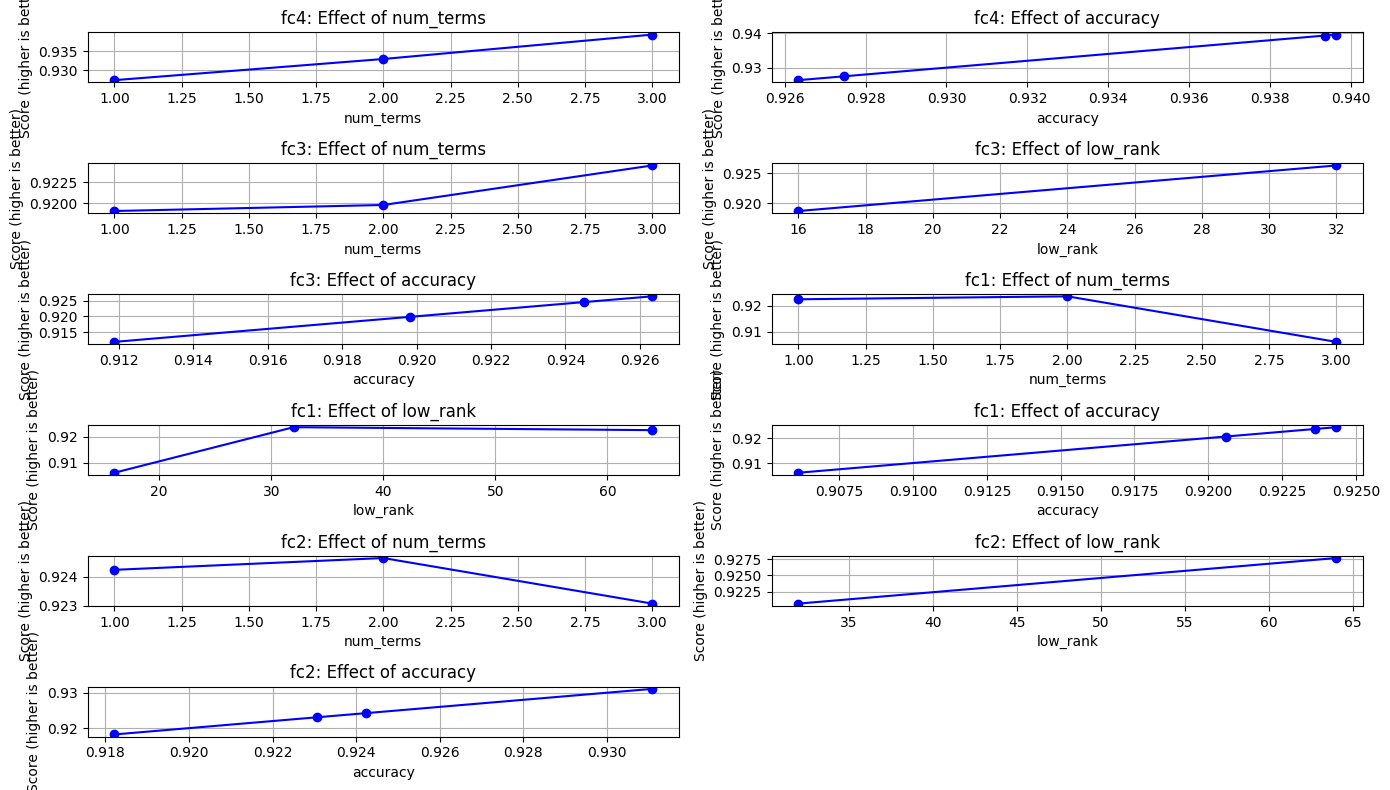

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

print("Visualizing tuning results...")
auto_tuner.visualize_tuning_results(show_plot=True, figsize=(14, 8))

## 6. Test Pattern-Based Layer Selection with AUTO

We can use patterns to select layers and still use `"auto"` for parameters.

In [44]:
# Create fresh model
enc_dec_model_2 = EncoderDecoderModel()

# Use pattern matching with auto params
pattern_config = TuningConfigs([
    LayerConfig(
        layer_names={"pattern": "encoder.*", "type": "Linear"},  # Select Linear layers in encoder
        params="auto",  # <<< AUTO
        separate=True,
    ),
    LayerConfig(
        layer_names={"pattern": "decoder.*", "type": "Linear"},  # Select Linear layers in decoder
        params="auto",  # <<< AUTO
        separate=False,  # Tune decoder layers jointly
    ),
])

print("Pattern-based config with 'auto':")
print(pattern_config)

Pattern-based config with 'auto':
TuningConfigs(configs=[LayerConfig(layer_names={'pattern': 'encoder.*', 'type': 'Linear'}, params=auto, separate=True, copy_weights=True), LayerConfig(layer_names={'pattern': 'decoder.*', 'type': 'Linear'}, params=auto, separate=False, copy_weights=True)])


In [45]:
# Create tuner to see resolved configs
search_pattern = OptunaSearch(n_trials=3, seed=123)

pattern_tuner = SKAutoTuner(
    model=enc_dec_model_2,
    configs=pattern_config,
    accuracy_eval_func=enc_dec_eval_func,
    search_algorithm=search_pattern,
    verbose=True,
)

print("\n" + "=" * 60)
print("RESOLVED PATTERN-BASED CONFIGS")
print("=" * 60)

# NOTE: When using params="auto", the tuner expands each layer separately
# based on its dimensions. The "separate" flag is effectively ignored
# because "auto" creates per-layer configs. To truly test joint tuning,
# use manual params (see Section 9).

resolved_pattern = pattern_tuner.getConfigs()
print(f"\nNumber of resolved configs: {len(resolved_pattern)}")

for i, config in enumerate(resolved_pattern):
    print(f"\n--- Config {i+1} ---")
    print(f"Layer names: {config.layer_names}")
    print(f"Parameters:")
    for param_name, param_spec in config.params.items():
        print(f"  {param_name}: {param_spec}")
    print(f"Separate: {config.separate}")


RESOLVED PATTERN-BASED CONFIGS

Number of resolved configs: 6

--- Config 1 ---
Layer names: ['encoder.0']
Parameters:
  num_terms: [1, 2, 3]
  low_rank: [16, 32, 64]
Separate: True

--- Config 2 ---
Layer names: ['encoder.2']
Parameters:
  num_terms: [1, 2, 3]
  low_rank: [16, 32, 64]
Separate: True

--- Config 3 ---
Layer names: ['encoder.4']
Parameters:
  num_terms: [1, 2, 3]
  low_rank: [16, 32]
Separate: True

--- Config 4 ---
Layer names: ['decoder.0']
Parameters:
  num_terms: [1, 2, 3]
  low_rank: [16, 32]
Separate: False

--- Config 5 ---
Layer names: ['decoder.2']
Parameters:
  num_terms: [1, 2, 3]
  low_rank: [16, 32, 64]
Separate: False

--- Config 6 ---
Layer names: ['decoder.4']
Parameters:
  num_terms: [1, 2, 3]
  low_rank: [16, 32, 64]
Separate: False


## 7. Test Manual Parameter Specification

Compare AUTO with manually specified parameters using ParamSpec types.

In [46]:
# Create fresh model
manual_model = SimpleMLPModel()

# Manual parameter specification with different ParamSpec types
manual_config = TuningConfigs([
    LayerConfig(
        layer_names=["fc1", "fc2"],
        params={
            "num_terms": Categorical([1, 2, 3]),  # Categorical choices
            "low_rank": Int(8, 64, step=8),       # Integer range with step
        },
        separate=True,
    )
])

print("Manual config with ParamSpec types:")
print(f"  Categorical: {Categorical([1, 2, 3])}")
print(f"  Int: {Int(8, 64, step=8)}")
print(f"\nFull config: {manual_config}")

Manual config with ParamSpec types:
  Categorical: Categorical([1, 2, 3])
  Int: Int(8, 64, step=8)

Full config: TuningConfigs(configs=[LayerConfig(layer_names=['fc1', 'fc2'], params={'num_terms': Categorical([1, 2, 3]), 'low_rank': Int(8, 64, step=8)}, separate=True, copy_weights=True)])


In [47]:
# Create and run tuner with manual params
search_manual = OptunaSearch(n_trials=4, seed=456)

manual_tuner = SKAutoTuner(
    model=manual_model,
    configs=manual_config,
    accuracy_eval_func=mlp_eval_func,
    search_algorithm=search_manual,
    verbose=True,
)

print("\nStarting tuning with MANUAL parameters...")
print("=" * 60)

best_params_manual = manual_tuner.tune()

print("\n" + "=" * 60)
print("MANUAL TUNING COMPLETE")
print("=" * 60)

for layer_name, data in best_params_manual.items():
    print(f"\nLayer: {layer_name}")
    if data and data.get('params'):
        print(f"  Best params: {data['params']}")

[I 2026-01-02 22:44:14,041] A new study created in memory with name: skautotuner_study
[I 2026-01-02 22:44:14,054] A new study created in memory with name: skautotuner_study



Starting tuning with MANUAL parameters...
Tuning layer: fc1
Trying parameters: {'num_terms': 3, 'low_rank': 56}
Replaced fc1 with sketched version using parameters: {'num_terms': 3, 'low_rank': 56}
run: 1/1 - accuracy_score: 0.9422024488449097, speed_score: None, final score: 0.9422024488449097
Tried parameters: {'num_terms': 3, 'low_rank': 56}, accuracy_score: 0.9422024488449097, speed_score: None, final score: 0.9422024488449097
Trying parameters: {'num_terms': 3, 'low_rank': 56}
Replaced fc1 with sketched version using parameters: {'num_terms': 3, 'low_rank': 56}
run: 1/1 - accuracy_score: 0.9421035721898079, speed_score: None, final score: 0.9421035721898079
Tried parameters: {'num_terms': 3, 'low_rank': 56}, accuracy_score: 0.9421035721898079, speed_score: None, final score: 0.9421035721898079
Trying parameters: {'num_terms': 3, 'low_rank': 32}
Replaced fc1 with sketched version using parameters: {'num_terms': 3, 'low_rank': 32}
run: 1/1 - accuracy_score: 0.9353406727313995, spee

## 8. Apply Best Parameters and Compare Models

In [48]:
from panther.nn.linear import SKLinear

# Apply best params from manual tuner
print("Before applying best params:")
print(f"  fc1 type: {type(manual_model.fc1).__name__}")
print(f"  fc2 type: {type(manual_model.fc2).__name__}")

manual_tuner.apply_best_params()

print("\nAfter applying best params:")
print(f"  fc1 type: {type(manual_model.fc1).__name__}")
print(f"  fc2 type: {type(manual_model.fc2).__name__}")

# Check if they're SKLinear
is_sketched = lambda m: isinstance(m, SKLinear)
print(f"\n  fc1 is SKLinear: {is_sketched(manual_model.fc1)}")
print(f"  fc2 is SKLinear: {is_sketched(manual_model.fc2)}")

Before applying best params:
  fc1 type: Linear
  fc2 type: Linear
replaced fc1 with SKLinear
replaced fc2 with SKLinear

After applying best params:
  fc1 type: SKLinear
  fc2 type: SKLinear

  fc1 is SKLinear: True
  fc2 is SKLinear: True


In [49]:
from panther.nn.linear import SKLinear

print("Model Summary After Applying Best Params:")
print("=" * 60)

# Define is_sketched function to highlight sketched layers
def is_sketched(module):
    return isinstance(module, SKLinear)

ModelVisualizer.print_model_summary(manual_model, is_sketched_func=is_sketched)

Model Summary After Applying Best Params:
Model Summary (Total trainable parameters: 318,400)
Sketched layers: 2
--------------------------------------------------------------------------------
Layer Name                               Layer Type                Parameters      Sketched
--------------------------------------------------------------------------------
fc1                                      SKLinear                  129,536         ✓
relu1                                    ReLU                      0               
fc2                                      SKLinear                  147,712         ✓
relu2                                    ReLU                      0               
fc3                                      Linear                    32,896          
relu3                                    ReLU                      0               
fc4                                      Linear                    8,256           


## 9. Test Joint Tuning (separate=False)

**Important Note:** When using `params="auto"`, the tuner expands each layer separately based on its dimensions, so the `separate` flag is effectively ignored. To properly test joint tuning where all layers share the same parameters, we must use **manual parameter specification**.

In [50]:
# Create fresh model for joint tuning
joint_model = SimpleMLPModel()

# Joint tuning config - all layers share the same parameters
# Using MANUAL params (not "auto") to properly test separate=False
joint_config = TuningConfigs([
    LayerConfig(
        layer_names=["fc1", "fc2"],
        params={
            "num_terms": Categorical([1, 2, 3]),
            "low_rank": Categorical([16, 32, 64]),
        },
        separate=False,  # <<< JOINT TUNING - layers share same params
    )
])

print("Joint tuning config (separate=False) with MANUAL params:")
print(joint_config)

Joint tuning config (separate=False) with MANUAL params:
TuningConfigs(configs=[LayerConfig(layer_names=['fc1', 'fc2'], params={'num_terms': Categorical([1, 2, 3]), 'low_rank': Categorical([16, 32, 64])}, separate=False, copy_weights=True)])


In [51]:
search_joint = OptunaSearch(n_trials=3, seed=789)

joint_tuner = SKAutoTuner(
    model=joint_model,
    configs=joint_config,
    accuracy_eval_func=mlp_eval_func,
    search_algorithm=search_joint,
    verbose=True,
)

print("\nStarting JOINT tuning (with manual params)...")
print("=" * 60)

best_params_joint = joint_tuner.tune()

print("\n" + "=" * 60)
print("JOINT TUNING COMPLETE")
print("=" * 60)

# In joint tuning, all layers should have the SAME parameters
print("\nVerifying all layers have same params (joint tuning):")
params_list = []
for layer_name, data in best_params_joint.items():
    params = data.get('params') if data else None
    params_list.append(params)
    print(f"  {layer_name}: {params}")

if len(params_list) >= 2:
    all_equal = all(p == params_list[0] for p in params_list)
    print(f"\n  All params equal: {all_equal}")
    if all_equal:
        print("  ✓ Joint tuning working correctly - all layers share same params!")
    else:
        print("  ✗ WARNING: Params differ - joint tuning may not be working!")

[I 2026-01-02 22:44:14,099] A new study created in memory with name: skautotuner_study



Starting JOINT tuning (with manual params)...
Trying parameters: {'num_terms': 3, 'low_rank': 32}
Replaced fc1 with sketched version using parameters: {'num_terms': 3, 'low_rank': 32}
Replaced fc2 with sketched version using parameters: {'num_terms': 3, 'low_rank': 32}
run: 1/1 - accuracy_score: 0.8974194899201393, speed_score: None, final score: 0.8974194899201393
Tried parameters: {'num_terms': 3, 'low_rank': 32}, accuracy_score: 0.8974194899201393, speed_score: -inf, final score: 0.8974194899201393
Trying parameters: {'num_terms': 3, 'low_rank': 64}
Replaced fc1 with sketched version using parameters: {'num_terms': 3, 'low_rank': 64}
Replaced fc2 with sketched version using parameters: {'num_terms': 3, 'low_rank': 64}
run: 1/1 - accuracy_score: 0.9233050495386124, speed_score: None, final score: 0.9233050495386124
Tried parameters: {'num_terms': 3, 'low_rank': 64}, accuracy_score: 0.9233050495386124, speed_score: -inf, final score: 0.9233050495386124
Trying parameters: {'num_terms'

### Compare: Joint (separate=False) vs Separate (separate=True) with Manual Params

In [52]:
# Compare separate=True vs separate=False behavior with manual params
# This demonstrates that "separate" flag only works correctly with manual params

print("=" * 60)
print("COMPARISON: separate=True vs separate=False (Manual Params)")
print("=" * 60)

# --- Test with separate=True ---
separate_model = SimpleMLPModel()
separate_config = TuningConfigs([
    LayerConfig(
        layer_names=["fc1", "fc2"],
        params={
            "num_terms": Categorical([1, 2]),
            "low_rank": Categorical([16, 32]),
        },
        separate=True,  # Each layer tuned independently
    )
])

separate_tuner = SKAutoTuner(
    model=separate_model,
    configs=separate_config,
    accuracy_eval_func=mlp_eval_func,
    search_algorithm=OptunaSearch(n_trials=2, seed=111),
    verbose=False,
)

print("\n--- separate=True (independent tuning) ---")
best_separate = separate_tuner.tune()
for layer_name, data in best_separate.items():
    print(f"  {layer_name}: {data.get('params') if data else None}")

# --- Test with separate=False ---
joint_model_2 = SimpleMLPModel()
joint_config_2 = TuningConfigs([
    LayerConfig(
        layer_names=["fc1", "fc2"],
        params={
            "num_terms": Categorical([1, 2]),
            "low_rank": Categorical([16, 32]),
        },
        separate=False,  # All layers share same params
    )
])

joint_tuner_2 = SKAutoTuner(
    model=joint_model_2,
    configs=joint_config_2,
    accuracy_eval_func=mlp_eval_func,
    search_algorithm=OptunaSearch(n_trials=2, seed=111),
    verbose=False,
)

print("\n--- separate=False (joint tuning) ---")
best_joint_2 = joint_tuner_2.tune()
for layer_name, data in best_joint_2.items():
    print(f"  {layer_name}: {data.get('params') if data else None}")

# Verify the difference
sep_params = [data.get('params') for data in best_separate.values()]
joint_params = [data.get('params') for data in best_joint_2.values()]

print("\n--- Verification ---")
print(f"  separate=True  -> params can differ: {sep_params[0] != sep_params[1] if len(sep_params) >= 2 else 'N/A'}")
print(f"  separate=False -> params must match: {joint_params[0] == joint_params[1] if len(joint_params) >= 2 else 'N/A'}")

[I 2026-01-02 22:44:14,128] A new study created in memory with name: skautotuner_study
[I 2026-01-02 22:44:14,132] A new study created in memory with name: skautotuner_study
[I 2026-01-02 22:44:14,139] A new study created in memory with name: skautotuner_study


COMPARISON: separate=True vs separate=False (Manual Params)

--- separate=True (independent tuning) ---
  fc1: {'num_terms': 1, 'low_rank': 32}
  fc2: {'num_terms': 2, 'low_rank': 16}

--- separate=False (joint tuning) ---
  fc1: {'num_terms': 1, 'low_rank': 32}
  fc2: {'num_terms': 1, 'low_rank': 32}

--- Verification ---
  separate=True  -> params can differ: True
  separate=False -> params must match: True


## 10. Test Save and Load Results

In [53]:
import tempfile
import os

# Save results to a temp file
with tempfile.TemporaryDirectory() as tmpdir:
    save_path = os.path.join(tmpdir, "tuning_results.pkl")
    
    print("Saving tuning results...")
    auto_tuner.save_tuning_results(save_path)
    print(f"  Saved to: {save_path}")
    print(f"  File exists: {os.path.exists(save_path)}")
    print(f"  File size: {os.path.getsize(save_path)} bytes")
    
    # Create a new tuner and load results
    new_model = SimpleMLPModel()
    new_search = OptunaSearch(n_trials=1)  # Won't actually be used
    
    new_tuner = SKAutoTuner(
        model=new_model,
        configs=auto_config,
        accuracy_eval_func=mlp_eval_func,
        search_algorithm=new_search,
    )
    
    print("\nLoading tuning results...")
    new_tuner.load_tuning_results(save_path)
    
    loaded_best = new_tuner.get_best_params()
    print("\nLoaded best params:")
    for layer, data in loaded_best.items():
        print(f"  {layer}: {data.get('params') if data else None}")
    
    print("\n✓ Save/Load test passed!")

Saving tuning results...
Tuning results saved to C:\Users\venom\AppData\Local\Temp\tmphbifyups\tuning_results.pkl
  Saved to: C:\Users\venom\AppData\Local\Temp\tmphbifyups\tuning_results.pkl
  File exists: True
  File size: 1339510 bytes

Loading tuning results...

Loaded best params:
  fc4: {'num_terms': 2, 'low_rank': 16}
  fc3: {'num_terms': 1, 'low_rank': 32}
  fc1: {'num_terms': 1, 'low_rank': 64}
  fc2: {'num_terms': 2, 'low_rank': 64}

✓ Save/Load test passed!


## 11. Test Replace Without Tuning

In [54]:
from panther.nn.linear import SKLinear

# Create fresh model
replace_model = SimpleMLPModel()

config_replace = TuningConfigs([
    LayerConfig(
        layer_names=["fc1"],
        params={"num_terms": [2], "low_rank": [16]},  # First values will be used
        separate=True,
    )
])

replace_tuner = SKAutoTuner(
    model=replace_model,
    configs=config_replace,
    accuracy_eval_func=mlp_eval_func,
    search_algorithm=OptunaSearch(n_trials=1),
)

print("Before replace_without_tuning:")
print(f"  fc1 type: {type(replace_model.fc1).__name__}")

# Replace without tuning - uses first param values
replace_tuner.replace_without_tuning()

print("\nAfter replace_without_tuning:")
print(f"  fc1 type: {type(replace_model.fc1).__name__}")
print(f"  fc1 is SKLinear: {isinstance(replace_model.fc1, SKLinear)}")

if isinstance(replace_model.fc1, SKLinear):
    print(f"  fc1.num_terms: {replace_model.fc1.num_terms}")
    print(f"  fc1.low_rank: {replace_model.fc1.low_rank}")

Before replace_without_tuning:
  fc1 type: Linear

After replace_without_tuning:
  fc1 type: SKLinear
  fc1 is SKLinear: True
  fc1.num_terms: 2
  fc1.low_rank: 16


## 12. Test AUTO with Conv2d Layers

In [55]:
# Create conv model
conv_auto_model = ConvModel()

# Use AUTO for conv layers
conv_auto_config = TuningConfigs([
    LayerConfig(
        layer_names={"type": "Conv2d"},  # Select all Conv2d layers
        params="auto",  # <<< AUTO for conv layers
        separate=True,
    )
])

print("Conv2d AUTO config:")
print(conv_auto_config)

Conv2d AUTO config:
TuningConfigs(configs=[LayerConfig(layer_names={'type': 'Conv2d'}, params=auto, separate=True, copy_weights=True)])


In [56]:
search_conv = OptunaSearch(n_trials=2, seed=999)

conv_tuner = SKAutoTuner(
    model=conv_auto_model,
    configs=conv_auto_config,
    accuracy_eval_func=conv_eval_func,
    search_algorithm=search_conv,
    verbose=True,
)

print("\n" + "=" * 60)
print("RESOLVED CONV2D AUTO CONFIGS")
print("=" * 60)

resolved_conv = conv_tuner.getConfigs()
print(f"\nNumber of resolved configs: {len(resolved_conv)}")

for i, config in enumerate(resolved_conv):
    print(f"\n--- Config {i+1} ---")
    print(f"Layer names: {config.layer_names}")
    print(f"Parameters:")
    for param_name, param_spec in config.params.items():
        print(f"  {param_name}: {param_spec}")

Iterative low_rank generation for nn.Conv2d with sizes (3, 32) and num_terms [1, 2, 3] yielded no efficient ranks starting from k=8 using formula (D1*D2) > (2*L*K*(D1+D2)). Applying fallback: [1, 2, 4, 8].

RESOLVED CONV2D AUTO CONFIGS

Number of resolved configs: 3

--- Config 1 ---
Layer names: ['conv1']
Parameters:
  num_terms: [1, 2, 3]
  low_rank: [8, 1, 2, 4]

--- Config 2 ---
Layer names: ['conv2']
Parameters:
  num_terms: [1, 2, 3]
  low_rank: [8]

--- Config 3 ---
Layer names: ['conv3']
Parameters:
  num_terms: [1, 2, 3]
  low_rank: [8, 16]


## 13. Export Model Structure

In [57]:
# Export model structure as JSON-compatible dict
print("Exporting model structure...")
export_data = ModelVisualizer.export_model_structure(mlp_model)

print(f"\nModel type: {export_data['model_type']}")
print(f"Total parameters: {export_data['total_parameters']:,}")
print(f"\nModule types:")
for name, mtype in export_data['module_types'].items():
    if name:  # Skip empty string (root)
        print(f"  {name}: {mtype}")

Exporting model structure...

Model type: SimpleMLPModel
Total parameters: 304,064

Module types:
  fc1: Linear
  relu1: ReLU
  fc2: Linear
  relu2: ReLU
  fc3: Linear
  relu3: ReLU
  fc4: Linear


## 14. Summary

This notebook tested the following tuner features:

- ✅ `params="auto"` for automatic parameter recommendation
- ✅ Pattern-based layer selection (`{"pattern": ..., "type": ...}`)
- ✅ ParamSpec types (`Categorical`, `Int`, `Float`)
- ✅ Separate tuning (`separate=True`)
- ✅ Joint tuning (`separate=False`)
- ✅ `apply_best_params()` to apply tuned parameters
- ✅ `replace_without_tuning()` to use first param values
- ✅ Save/load tuning results
- ✅ ModelVisualizer for inspection and visualization
- ✅ Conv2d layer tuning with AUTO

In [58]:
print("=" * 60)
print("ALL MANUAL TESTS COMPLETED SUCCESSFULLY!")
print("=" * 60)

ALL MANUAL TESTS COMPLETED SUCCESSFULLY!
